In [11]:
%matplotlib inline
# %matplotlib notebook

import datetime
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# current date 2020.06.15

astroTwiStartStr = "2020-06-15T23:30:00"
noonAtStr = "2020-06-16T12:00:00"

dtFormat = "%Y-%m-%dT%H:%M:%S"
sunSetAt = datetime.datetime.strptime("2020-06-15T21:19:00", dtFormat)
sunRiseAt = datetime.datetime.strptime("2020-06-16T04:45:00", dtFormat)
astroTwiStartAt = datetime.datetime.strptime(astroTwiStartStr, dtFormat)
astroTwiEndAt = datetime.datetime.strptime("2020-06-16T02:30:00", dtFormat)

noonAt = datetime.datetime.strptime(noonAtStr, dtFormat)

# https://en.wikipedia.org/wiki/Sigmoid_function
def sigmoid(x):
    return 1 / (1 + math.pow(math.e, (x * -1)))


# https://en.wikipedia.org/wiki/Generalised_logistic_function
def gen_logistic_curve(b, q, v, t):
    a = 0
#     b = 0.7
    k = 1.0
#     q = 0.5
#     v = 0.5
    m = 0
    c = 1
    return a + ((k - a) / (math.pow(c + q * (math.pow(math.e, (b * t) * -1)), (1 / v))))


def remap_current_time_to_curve_range(t1, t2, now):
    curve_zone_start = -6
    curve_zone_end = 6
    polate = interp1d([t1, t2], [curve_zone_start, curve_zone_end])
    return polate(now)


def curve_to_setting(curve, min, max):
    interpol = interp1d([0, 1], [min, max])
    return interpol(curve)


def ev(iso, shutter_speed, aperture):
    ev100 = math.log2(math.pow(aperture, 2) / shutter_speed)
    if iso > 100:
        return ev100 + math.log2(iso / 100)
    else:
        return ev100


def curve_for_instant(slope, shift, soft_start, t):
    remapped = remap_current_time_to_curve_range(astroTwiStartAt.timestamp(), noonAt.timestamp(), t.timestamp())
    return gen_logistic_curve(slope, shift, soft_start, remapped)


def settings_for_instant(slope, shift, soft_start, min, max, t):
    remapped_curve = curve_for_instant(slope, shift, soft_start, t)
    return curve_to_setting(remapped_curve, min, max)


prev_ss = 15
prev_iso = 1600
prev_ev = -16

def reset_globals():
    global prev_ss
    global prev_iso
    global prev_ev
    prev_ss = 15
    prev_iso = 1600
    prev_ev = -16
    

def adjusting_curves(iso, ss, aperture, which):
    global prev_ss
    global prev_iso
    global prev_ev
    e = ev(iso, ss, aperture)
    if e < prev_ev:
        if which == 'iso':
            print("Adjusting iso: " + str(iso) + "->" + str(prev_iso) + " - ev: " +  str(e) + " < prev_ev: " + str(prev_ev))
            return prev_iso
        else:
            print("Adjusting ss: " + str(ss) + "->" + str(prev_ss) + " - ev: " +  str(e) + " < prev_ev: " + str(prev_ev))
            return prev_ss
    else:
        prev_ev = e
        if which == 'iso':
            prev_iso = iso
            print("iso: " + str(iso) + " - ev is ok:" +  str(e))
            return iso
        else:
            prev_ss = ss
            print("ss: " + str(ss) + " - ev is ok:" +  str(e))
            return ss


ss_slope = 2.5
ss_shift = 1.0
ss_soft_start = 1.0

iso_slope = 2.5
iso_shift = 0.099
iso_soft_start = 1.0

ss_min = 15
ss_max = 1/8000

iso_min = 1600
iso_max = 100

resolution = 12

df = pd.DataFrame({
    'date_time': pd.DatetimeIndex(pd.to_datetime(astroTwiStartStr) + pd.to_timedelta(np.arange(resolution), 'h')),
    'aperture': pd.Series(np.full(resolution, 2.8), dtype='float64')
})

df['shutter_speed_curve'] = pd.Series(df.apply(lambda r: curve_for_instant(ss_slope, ss_shift, ss_soft_start, r['date_time']), axis=1), dtype='float64')
df['iso_curve'] = pd.Series(df.apply(lambda r: curve_for_instant(iso_slope, iso_shift, iso_soft_start, r['date_time']), axis=1), dtype='float64')

df['shutter_speed'] = pd.Series(df.apply(lambda r: settings_for_instant(ss_slope, ss_shift, ss_soft_start, ss_min, ss_max, r['date_time']), axis=1), dtype='float64')
df['iso'] = pd.Series(df.apply(lambda r: settings_for_instant(iso_slope, iso_shift, iso_soft_start, iso_min, iso_max, r['date_time']), axis=1), dtype='float64')

cut_labels_iso = [100, 200, 400, 800, 1600]
cut_bins_iso = [100, 150, 300, 600, 1200, 3200]
df['cut_iso'] = pd.cut(df['iso'], bins=cut_bins_iso, labels=cut_labels_iso)

cut_labels_shutter_speed = [1/8000, 1/4000, 1/2000, 1/1000, 1/500, 1/250, 1/125, 1/60, 1/30, 1/15, 1/8, 1/4, 1/2, 1, 2, 4, 8, 15]
cut_bins_shutter_speed = [1/8000, 1/6000, 1/4000, 1/3000, 1/750, 1/375, 1/190, 1/90, 1/45, 1/22, 1/11, 1/6, 1/3, 0.75, 1.5, 3, 6, 11, 15]
df['cut_shutter_speed'] = pd.cut(df['shutter_speed'], bins=cut_bins_shutter_speed, labels=cut_labels_shutter_speed)

# Shutter Speed driven?
# reset_globals()
# df['cut_iso_adjusted'] = pd.Series(df.apply(lambda r: adjusting_curves(r['cut_iso'], r['cut_shutter_speed'], r['aperture'], 'iso'), axis=1), dtype='float64')
# reset_globals()
# df['cut_shutter_speed_adjusted'] = pd.Series(df.apply(lambda r: adjusting_curves(r['cut_iso_adjusted'], r['cut_shutter_speed'], r['aperture'], 'ss'), axis=1), dtype='float64')

# ISO driven?
print("adjust ss")
reset_globals()
df['cut_shutter_speed_adjusted'] = pd.Series(df.apply(lambda r: adjusting_curves(r['cut_iso'], r['cut_shutter_speed'], r['aperture'], 'ss'), axis=1), dtype='float64')
# print("adjust iso")
# reset_globals()
# df['cut_iso_adjusted'] = pd.Series(df.apply(lambda r: adjusting_curves(r['cut_iso'], r['cut_shutter_speed_adjusted'], r['aperture'], 'iso'), axis=1), dtype='float64')
df['cut_iso_adjusted'] = df['cut_iso']


df['ev'] = df.apply(lambda row: ev(row['cut_iso_adjusted'], row['cut_shutter_speed_adjusted'], row['aperture']), axis=1)

# df = df.set_index('date_time')
display(df)
# df.head(20)

adjust ss
ss: 15.0 - ev is ok:3.063963058731965
ss: 15.0 - ev is ok:3.063963058731965
ss: 15.0 - ev is ok:3.063963058731965
ss: 15.0 - ev is ok:3.063963058731965
Adjusting ss: 15.0->15.0 - ev: 2.063963058731965 < prev_ev: 3.063963058731965
Adjusting ss: 8.0->15.0 - ev: 1.9708536543404833 < prev_ev: 3.063963058731965
Adjusting ss: 2.0->15.0 - ev: 1.9708536543404833 < prev_ev: 3.063963058731965
ss: 0.25 - ev is ok:4.970853654340483
ss: 0.016666666666666666 - ev is ok:8.877744249949002
ss: 0.002 - ev is ok:11.936637939002571
ss: 0.0005 - ev is ok:13.936637939002571
ss: 0.000125 - ev is ok:15.936637939002571


,date_time,aperture,shutter_speed_curve,iso_curve,shutter_speed,iso,cut_iso,cut_shutter_speed,cut_shutter_speed_adjusted,cut_iso_adjusted,ev
0,2020-06-15 23:30:00,2.8,0.000003,0.000034,14.999949,1599.948911,1600,15.000000,15.000000,1600,3.063963
1,2020-06-16 00:30:00,2.8,0.000037,0.000375,14.999442,1599.437025,1600,15.000000,15.000000,1600,3.063963
2,2020-06-16 01:30:00,2.8,0.000410,0.004122,14.993857,1593.817482,1600,15.000000,15.000000,1600,3.063963
3,2020-06-16 02:30:00,2.8,0.004496,0.043631,14.932556,1534.552790,1600,15.000000,15.000000,1600,3.063963
4,2020-06-16 03:30:00,2.8,0.047426,0.334620,14.288618,1098.070609,800,15.000000,15.000000,800,2.063963
5,2020-06-16 04:30:00,2.8,0.354344,0.847178,9.684889,329.233301,400,8.000000,15.000000,400,1.063963
6,2020-06-16 05:30:00,2.8,0.858149,0.983899,2.127873,124.151653,100,2.000000,15.000000,100,-0.936037
7,2020-06-16 06:30:00,2.8,0.985226,0.998518,0.221734,102.223542,100,0.250000,0.250000,100,4.970854
8,2020-06-16 07:30:00,2.8,0.998641,0.999865,0.020503,100.201987,100,0.016667,0.016667,100,8.877744
9,2020-06-16 08:30:00,2.8,0.999877,0.999988,0.001976,100.018326,100,0.002000,0.002000,100,11.936638


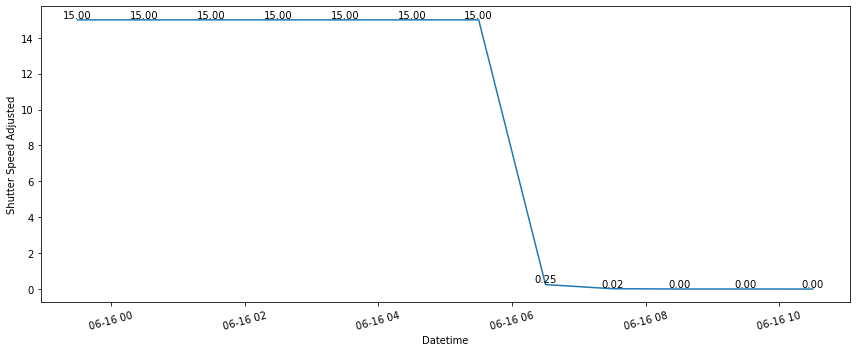

ValueError: Image size of 856x107750 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x360 with 1 Axes>

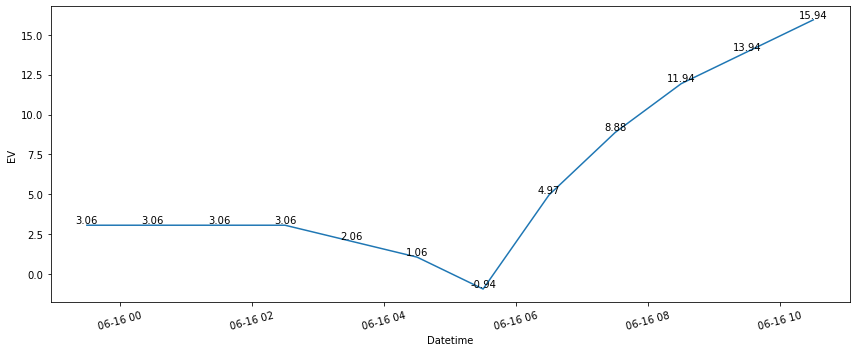

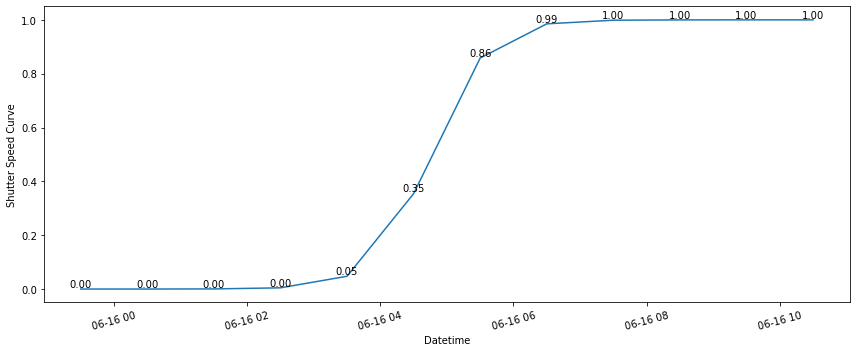

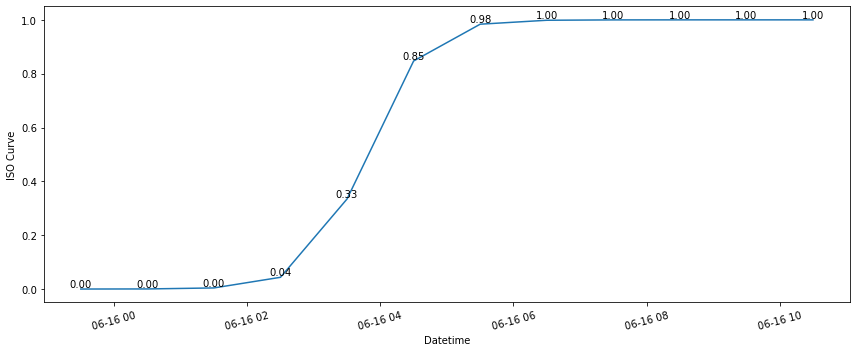

In [12]:
def show_plot(x, y, y_label):
    plt.rcParams["figure.figsize"] = (12,5)
    plt.xticks(rotation=15)
    plt.xlabel("Datetime")
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.tight_layout()
    for xs,ys in zip(x,y):
        label = "{:.2f}".format(ys)
        plt.annotate(label, # this is the text
                     (xs,ys), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,2), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()

# show_plot(df['date_time'], df['shutter_speed'], "Shutter Speed Curve")
# show_plot(df['date_time'], df['cut_shutter_speed'], "Shutter Speed")
show_plot(df['date_time'], df['cut_shutter_speed_adjusted'], "Shutter Speed Adjusted")
# show_plot(df['date_time'], df['iso'], "ISO Curve")
# show_plot(df['date_time'], df['cut_iso'], "ISO")
show_plot(df['date_time'], df['cut_iso_adjusted'], "ISO Adjusted")
show_plot(df['date_time'], df['ev'], "EV")
show_plot(df['date_time'], df['shutter_speed_curve'], "Shutter Speed Curve")
show_plot(df['date_time'], df['iso_curve'], "ISO Curve")